# Visualise Clusters


## 1. Setup

```bash
conda update -n base -c defaults conda
conda install -c conda-forge hdbscan
```

In [1]:
!lspcu

/bin/bash: lspcu: command not found


In [2]:
!git clone https://github.com/boringPpl/presidential_debates_comments_clustering.git
%cd presidential_debates_comments_clustering
!pip install -q hdbscan umap-learn

Cloning into 'presidential_debates_comments_clustering'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 226 (delta 25), reused 58 (delta 24), pack-reused 167
Receiving objects: 100% (226/226), 138.90 MiB | 29.57 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Checking out files: 100% (38/38), done.
/content/presidential_debates_comments_clustering
     |████████████████████████████████| 6.4MB 31.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 1.1MB 48.1MB/s 


In [3]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
# !head -1 cluster_data/vecs1_5k.tsv
# vecs1 = pd.read_csv("cluster_data/vecs1_5k.tsv", sep='\t', header=None)
# vecs2 = pd.read_csv("cluster_data/vecs2_5k.tsv", sep='\t', header=None)
vecs1 = pd.read_parquet("cluster_data/vecs1.parquet")
vecs2 = pd.read_parquet("cluster_data/vecs2.parquet")
print(f"Shape of vecs1: {vecs1.shape}")
print(f"Shape of vecs2: {vecs2.shape}")

Shape of vecs1: (50889, 50)
Shape of vecs2: (47164, 50)


In [5]:
# meta_lab1 = pd.read_csv("cluster_data/meta_lab1_5k.tsv", sep='\t')
# meta_lab2 = pd.read_csv("cluster_data/meta_lab2_5k.tsv", sep='\t')
meta_lab1 = pd.read_parquet("cluster_data/meta_lab1.parquet")
meta_lab2 = pd.read_parquet("cluster_data/meta_lab2.parquet")
print(f"Shape of meta_lab1: {meta_lab1.shape}")
print(f"Shape of meta_lab2: {meta_lab2.shape}")

Shape of meta_lab1: (50889, 2)
Shape of meta_lab2: (47164, 2)


## 2. Create Clusters

In [6]:
clusterer = hdbscan.HDBSCAN()  # (min_cluster_size=5, gen_min_span_tree=True)

The following takes about 1.5 minutes

In [7]:
%time clusterer.fit(vecs1)

CPU times: user 45.5 s, sys: 306 ms, total: 45.8 s
Wall time: 2min 53s


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [8]:
df0 = pd.concat((
    pd.DataFrame({
        'labels': clusterer.labels_,
        'probs': clusterer.probabilities_
    }),
    pd.DataFrame(vecs1)
), axis=1)

## 3. Trim Points to n-Color Palette

In [9]:
palette = sns.color_palette()
n = len(palette)  # There are only about 10 colors in the palette

In [10]:
df = df0.loc[(df0.labels > 0) & (df0.labels < n), :].copy()
df_vecs = df.iloc[:, 2:].T.values

In [11]:
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(df.labels.values, df.probs.values)]

## 4. Visualize Cluster

### 4.1 Principal Component Analysis

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_vecs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

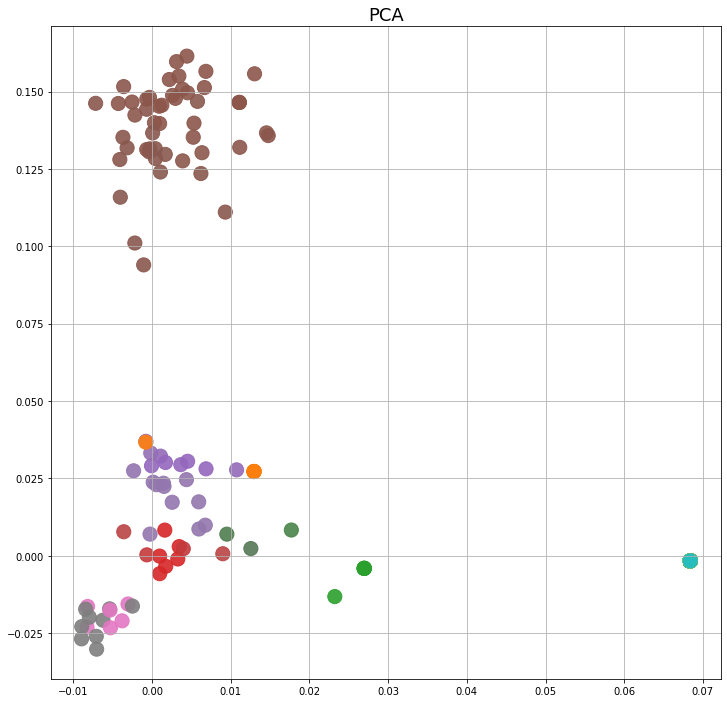

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(pca.components_[0], pca.components_[1], c=cluster_colors, s=200, alpha=0.9)
ax.grid(True)
ax.set_title("PCA", fontsize=18);

### 4.2 TSNE

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
clustertsne = tsne.fit_transform(df_vecs.T)
assert clustertsne.shape[0]==len(cluster_colors)

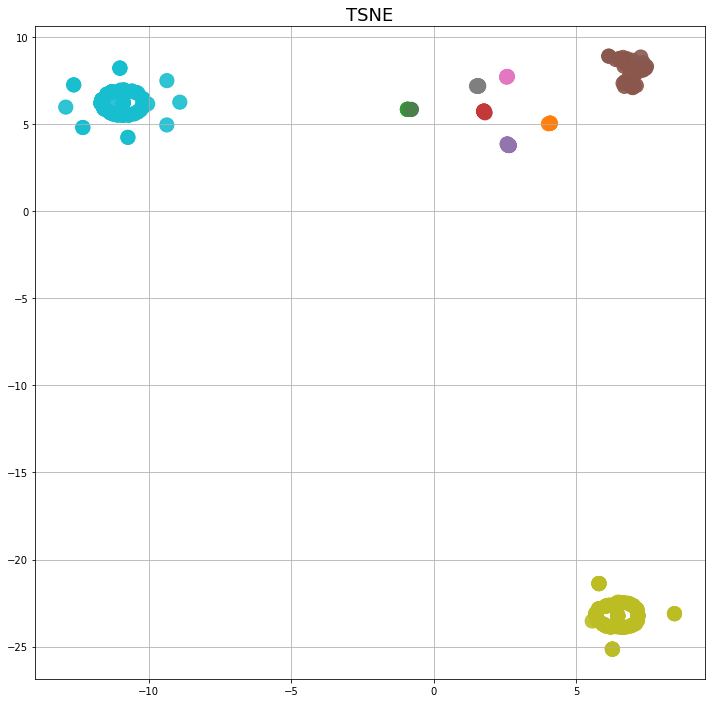

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(clustertsne[:, 0], clustertsne[:, 1], c=cluster_colors, s=200, alpha=0.9)
ax.grid(True)
ax.set_title("TSNE", fontsize=18);

### 4.3 UMAP

In [14]:
import umap

obj = umap.UMAP()
embedding = obj.fit_transform(df_vecs.T)
assert embedding.shape[0] == len(cluster_colors)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


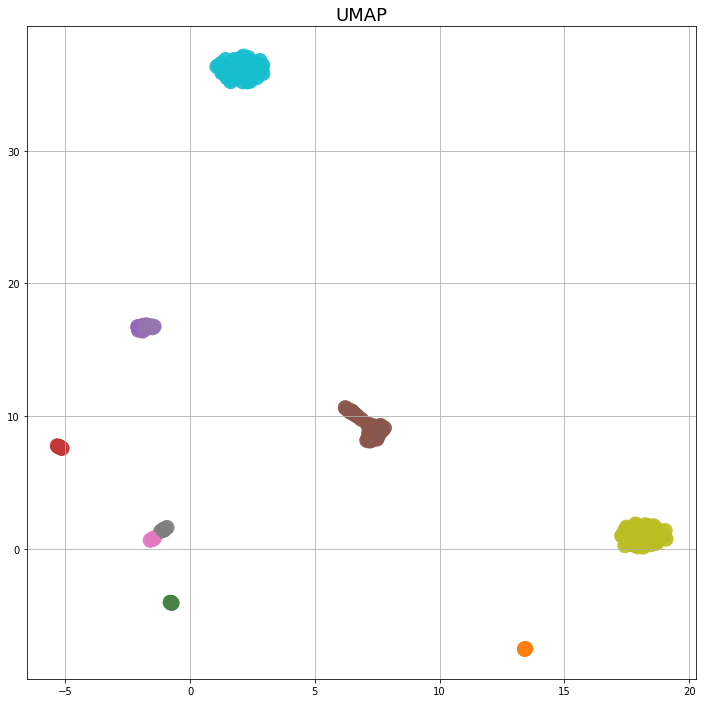

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(embedding[:, 0], embedding[:, 1], c=cluster_colors, s=200, alpha=0.9)
ax.grid(True)
ax.set_title("UMAP", fontsize=18);

### 4.4 K-Means

Text(0.5, 1.0, 'Elbow Method For Optimal k')

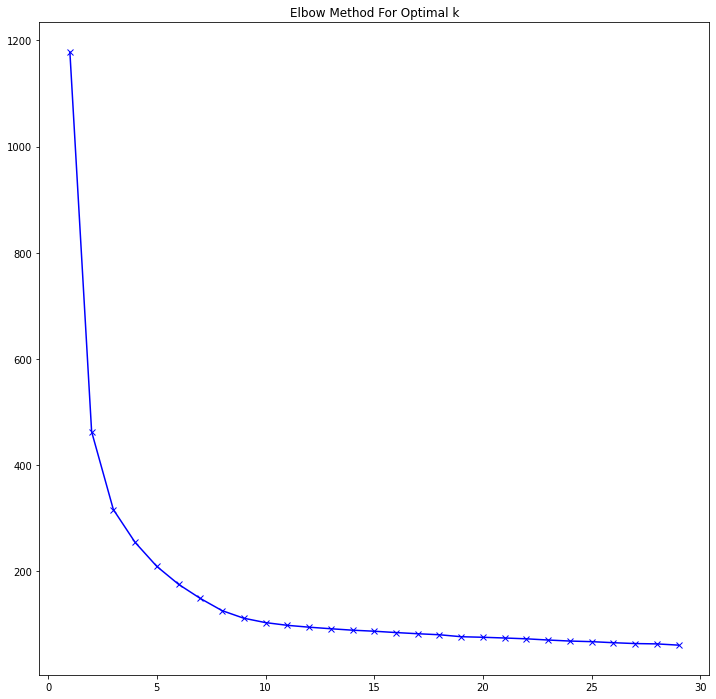

In [22]:
from sklearn.cluster import KMeans

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_vecs.T)
    Sum_of_squared_distances.append(km.inertia_)
ax.plot(K, Sum_of_squared_distances, 'bx-')
ax.set_title('Elbow Method For Optimal k')


Text(0.5, 1.0, 'K-Means')

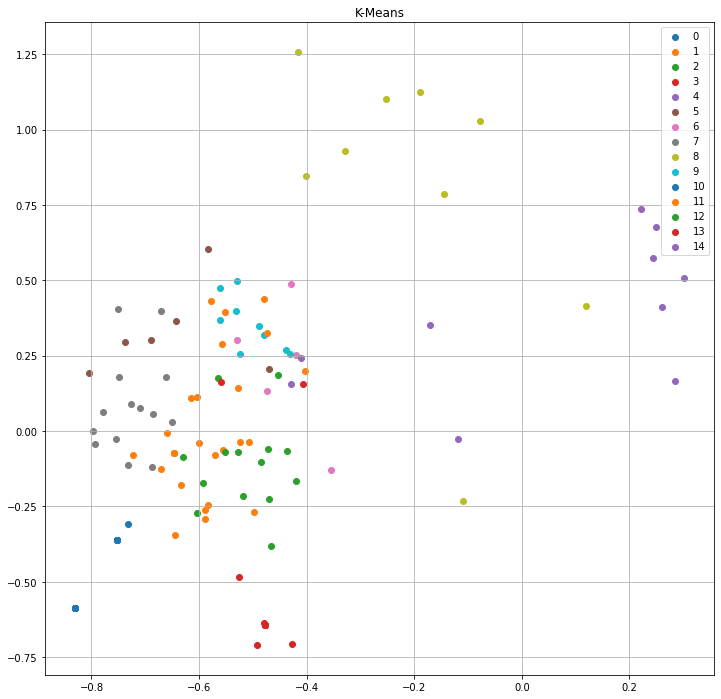

In [39]:
kmeans = KMeans(n_clusters=15)
label = kmeans.fit_predict(df_vecs.T)
u_labels = np.unique(label)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
for i in u_labels:
    ax.scatter(df_vecs.T[label == i , 0] , df_vecs.T[label == i , 1] , label = i)
ax.legend()
ax.grid(True)
ax.set_title('K-Means')

### 4.5 HDBScan

Text(0.5, 1.0, 'HDBScan')

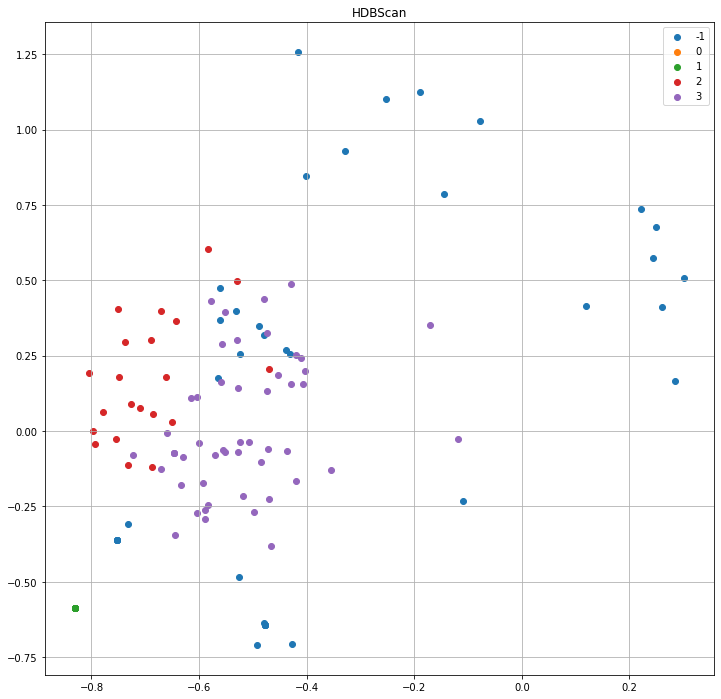

In [40]:
clusterhdb = hdbscan.HDBSCAN(min_cluster_size=15)
label = clusterhdb.fit_predict(df_vecs.T)

u_labels = np.unique(label)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
for i in u_labels:
    ax.scatter(df_vecs.T[label == i , 0] , df_vecs.T[label == i , 1] , label = i)
ax.legend()
ax.grid(True)
ax.set_title('HDBScan')